In [1]:
import random
import math

# Pruebas Montecarlo

# Lectura de datos

In [2]:
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize

In [3]:
def cargar_fichero(fichero="resultados.out"):
    filas = []
    with open(fichero, "r") as f:
        content = f.read()
        content = re.split(r'Ejecutando con (\d+) nodos, (\d+) procesadores y (\d+) iteraciones', content)[1:]
                
        for n_nodos, n_procesadores, its, resultados in [(content[i],content[i+1],content[i+2],content[i+3]) for i in range(0,len(content),4)]:   
            n_nodos = int(n_nodos)
            n_procesadores = int(n_procesadores)
            n_iteraciones = int(its)
            
            # Obtener aproximación global de esta ejecución.
            pattern = r"Global approx of PI with (\d+) iterations:\n" \
              r"\s+-is (\d+\.\d+)\n" \
              r"\s+-has an error [+-]?(\d+\.\d+e[+-]?\d+)\n" \
              r"\s+-took (\d+\.\d+e[+-]?\d+) seconds\n" \
              r"\s+-quality ([+-]?\d+\.\d+e[+-]?\d+|inf)"
            matches = re.finditer(pattern, resultados)
            try:
                match = next(matches)
            except:
                print(f"No se encontró aproximación global para {n_nodos} nodos y {n_procesadores} procesadores")
                continue
            iterations, pi_approx, error, time_taken, quality = match.groups()

            filas.append({
                "nodos": n_nodos,
                "procesadores": n_procesadores,
                "iteraciones": n_iteraciones,
                "procesador": -1,
                "iteraciones": int(iterations),
                "pi_approx": float(pi_approx),
                "error": float(error),
                "tiempo": float(time_taken),
                "calidad": float(quality),
            })
            
            # Obtener aproximaciones locales de cada uno de los procesos.
            pattern = r"Local (\d+) approx of PI with (\d+) iterations:\n" \
              r"\s+-is (\d+\.\d+)\n" \
              r"\s+-has an error [+-]?(\d+\.\d+e[+-]?\d+)\n" \
              r"\s+-took (\d+\.\d+e[+-]?\d+) seconds\n" \
              r"\s+-quality ([+-]?\d+\.\d+e[+-]?\d+|inf)"
            matches = re.finditer(pattern, resultados)
            for match in matches:
                processor, iterations, pi_approx, error, time_taken, quality = match.groups()
                filas.append({
                    "nodos": n_nodos,
                    "procesadores": n_procesadores,
                    "iteraciones": n_iteraciones,
                    "procesador": int(processor),
                    "iteraciones": int(iterations),
                    "pi_approx": float(pi_approx),
                    "error": float(error),
                    "tiempo": float(time_taken),
                    "calidad": float(quality),
                })
                
    df = pd.DataFrame(filas)
    del filas
    
    return df

In [4]:
def grafica_en_funcion_de_procesadores(df, tipo, n_nodos=2, n_iteraciones=10000000000):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

    # Ejecución global con 8 nodos
    df1 = df.loc[(df['nodos'] == n_nodos) & (df['procesador'] == -1) & (df['iteraciones'] == n_iteraciones)]

    # Subgráfica 1: Tiempo tomado en función del número de procesadores
    ax1.plot(df1['procesadores'], df1['tiempo'], marker='o', linestyle='-')
    ax1.grid()
    ax1.set_ylabel('Tiempo (s)')
    ax1.set_title(f'Tiempo y Calidad en función de # Procesadores ({n_nodos} Nodos y {n_iteraciones:.1e} Iteraciones)')

    # Subgráfica 2: Calidad en función del número de procesadores
    ax2.plot(df1['procesadores'], df1['calidad'], marker='o', linestyle='-')
    ax2.grid()
    ax2.set_ylabel('Calidad')

    # Subgráfica 3: Calidad en función del número de procesadores
    ax3.plot(df1['procesadores'], df1['error'], marker='o', linestyle='-')
    ax3.grid()
    ax3.set_xlabel('# Procesadores')
    ax3.set_ylabel('Error')

    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{tipo}-en-base-a-procesadores.png', dpi=400)

    return fig

In [5]:
def grafica_en_funcion_de_nodos(df, tipo, n_procesadores=16, n_iteraciones=10000000000):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 5), sharex=True)

    # Ejecución global con 16 procesadores
    df1 = df.loc[(df['procesadores'] == n_procesadores) & (df['procesador'] == -1) & (df['iteraciones'] == n_iteraciones)]

    # Subgráfica 1: Tiempo tomado en función del número de procesadores
    ax1.plot(df1['nodos'], df1['tiempo'], marker='o', linestyle='-')
    ax1.grid()
    ax1.set_ylabel('Tiempo (s)')
    ax1.set_title(f'Tiempo y Calidad en función de # Nodos ({n_procesadores} Procesadores y {n_iteraciones:.1e} Iteraciones)')

    # Subgráfica 2: Calidad en función del número de procesadores
    ax2.plot(df1['nodos'], df1['calidad'], marker='o', linestyle='-')
    ax2.grid()
    ax2.set_ylabel('Calidad')

    # Subgráfica 3: Calidad en función del número de procesadores
    ax3.plot(df1['nodos'], df1['error'], marker='o', linestyle='-')
    ax3.grid()
    ax3.set_xlabel('# Nodos')
    ax3.set_ylabel('Error')
    ax3.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{tipo}-en-base-a-nodos.png', dpi=400)

    return fig

In [6]:
def grafica_3D(df, tipo, n_iteraciones=10000000000):
    df1 = df.loc[df['iteraciones'] == n_iteraciones]

    df_error = df1[['nodos', 'procesadores', 'error']]
    df_tiempo = df1[['nodos', 'procesadores', 'tiempo']]
    df_calidad = df1[['nodos', 'procesadores', 'calidad']]

    # Crear una figura de subplots 1x3 para las tres medidas en el eje Z
    fig = plt.figure(figsize=(10, 5))

    # Crear un colormap para los puntos basado en la columna 'nodos'
    norm = Normalize(vmin=df['nodos'].min(), vmax=df['nodos'].max())
    cmap = plt.get_cmap('viridis')

    # Subplot para el tiempo
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(df_tiempo['nodos'], df_tiempo['procesadores'], df_tiempo['tiempo'], c=df_tiempo['nodos'], cmap=cmap, norm=norm)
    ax1.set_xlabel('Nodos')
    ax1.set_ylabel('Procesadores')
    ax1.set_zlabel('Tiempo')
    ax1.set_title('Gráfico de Tiempo', y=0.95)
    ax1.view_init(elev=5, azim=45)

    # Subplot para el error
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(df_error['nodos'], df_error['procesadores'], df_error['error'], c=df_error['nodos'], cmap=cmap, norm=norm)
    ax2.set_xlabel('Nodos')
    ax2.set_ylabel('Procesadores')
    ax2.set_zlabel('Error')
    ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='z', useMathText=True, useOffset=True)
    ax2.view_init(elev=15, azim=-45)

    # Subplot para la calidad
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(df_calidad['nodos'], df_calidad['procesadores'], df_calidad['calidad'], c=df_calidad['nodos'], cmap=cmap, norm=norm)
    ax3.set_xlabel('Nodos')
    ax3.set_ylabel('Procesadores')
    ax3.set_zlabel('Calidad')
    ax3.set_title('Gráfico de Calidad', y=0.95)
    ax3.ticklabel_format(style='sci', scilimits=(0,0), axis='z', useMathText=True, useOffset=True)
    ax3.view_init(elev=15, azim=-45)

    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout(pad=4.5)
    plt.savefig(f'figuras/{tipo}-3D.png', dpi=400)

    return fig

In [7]:
def grafica_en_funcion_de_iteraciones(df, tipo, n_nodos=4, n_procesadores=16):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 5), sharex=True)

    # Ejecución global con 8 nodos
    df1 = df.loc[(df['nodos'] == n_nodos) & (df['procesadores'] == n_procesadores) & (df['procesador'] == -1)]

    # Subgráfica 1: Tiempo tomado en función del número de procesadores
    ax1.plot(df1['iteraciones'], df1['tiempo'], marker='o', linestyle='-')
    ax1.grid()
    ax1.set_ylabel('Tiempo (s)')
    ax1.set_title(f'Tiempo y Calidad en función de # Iteraciones ({n_nodos} Nodos y {n_procesadores} Procesadores)')
    ax1.set_xscale('log')

    # Subgráfica 2: Calidad en función del número de procesadores
    ax2.plot(df1['iteraciones'], df1['calidad'], marker='o', linestyle='-')
    ax2.grid()
    ax2.set_ylabel('Calidad')
    ax2.set_xscale('log')

    # Subgráfica 3: Calidad en función del número de procesadores
    ax3.plot(df1['iteraciones'], df1['error'], marker='o', linestyle='-')
    ax3.grid()
    ax3.set_xlabel('Iteraciones')
    ax3.set_ylabel('Error')
    ax3.set_xscale('log')

    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{tipo}-en-base-a-iteraciones.png', dpi=400)

    return fig

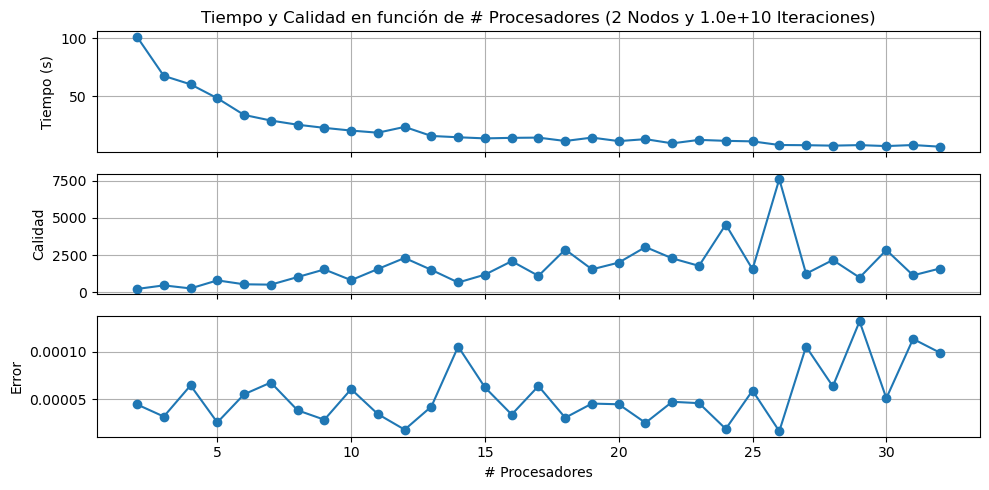

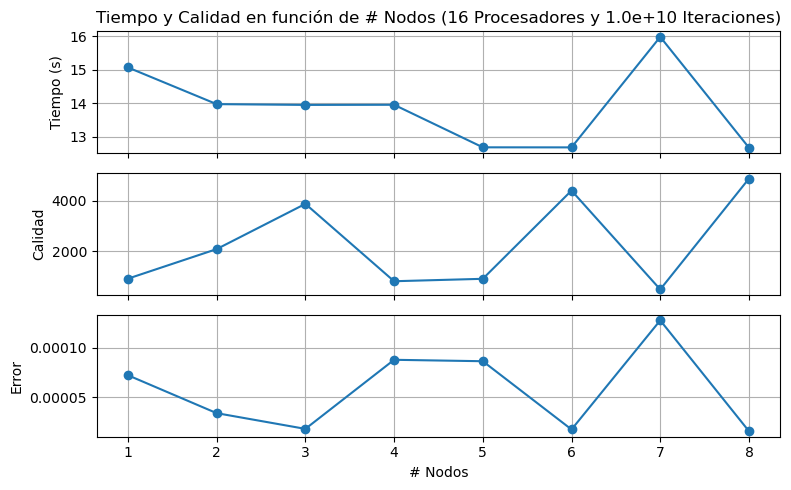

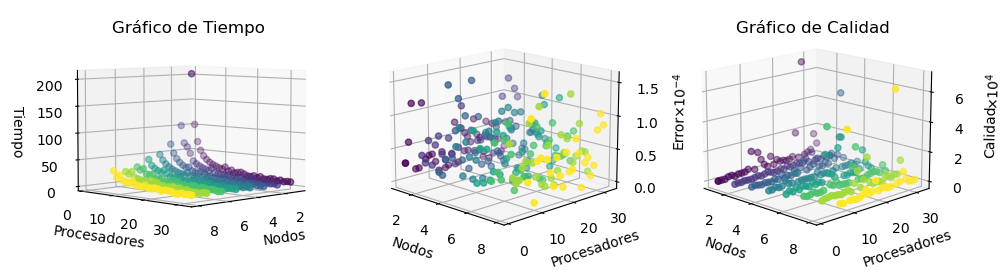

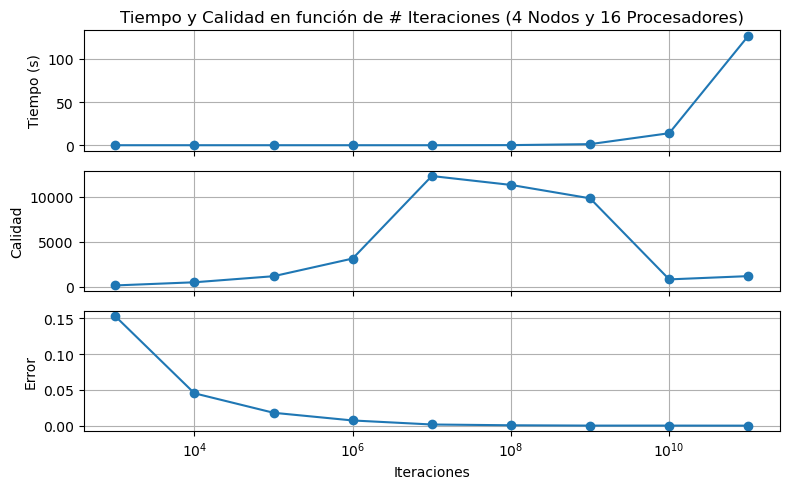

In [8]:
df = cargar_fichero("montecarlo_2.out")
_ = grafica_en_funcion_de_procesadores(df, "montecarlo")
_ = grafica_en_funcion_de_nodos(df, "montecarlo")
_ = grafica_3D(df, "montecarlo")
_ = grafica_en_funcion_de_iteraciones(df, "montecarlo")

No se encontró aproximación global para 1 nodos y 21 procesadores
No se encontró aproximación global para 1 nodos y 22 procesadores
No se encontró aproximación global para 1 nodos y 23 procesadores
No se encontró aproximación global para 1 nodos y 24 procesadores
No se encontró aproximación global para 1 nodos y 25 procesadores
No se encontró aproximación global para 1 nodos y 26 procesadores
No se encontró aproximación global para 1 nodos y 27 procesadores
No se encontró aproximación global para 1 nodos y 28 procesadores
No se encontró aproximación global para 1 nodos y 29 procesadores
No se encontró aproximación global para 1 nodos y 30 procesadores
No se encontró aproximación global para 1 nodos y 31 procesadores
No se encontró aproximación global para 1 nodos y 32 procesadores


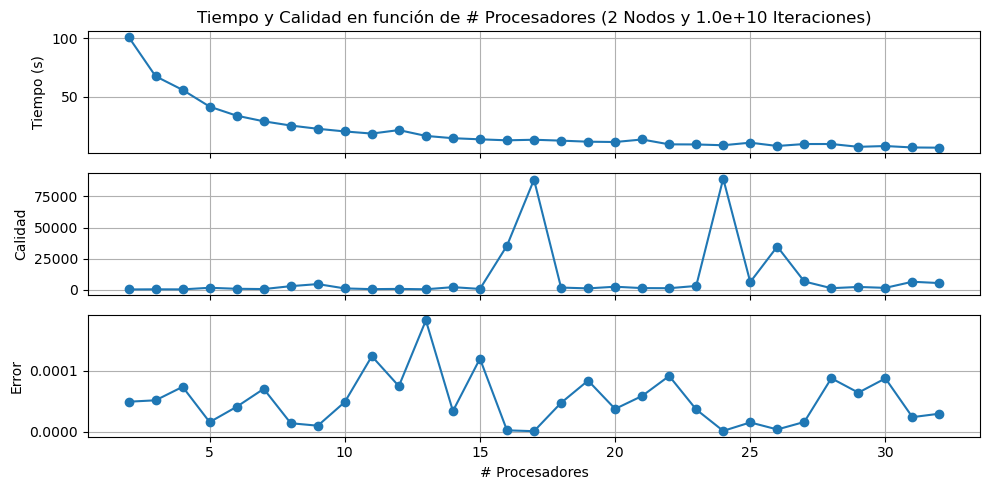

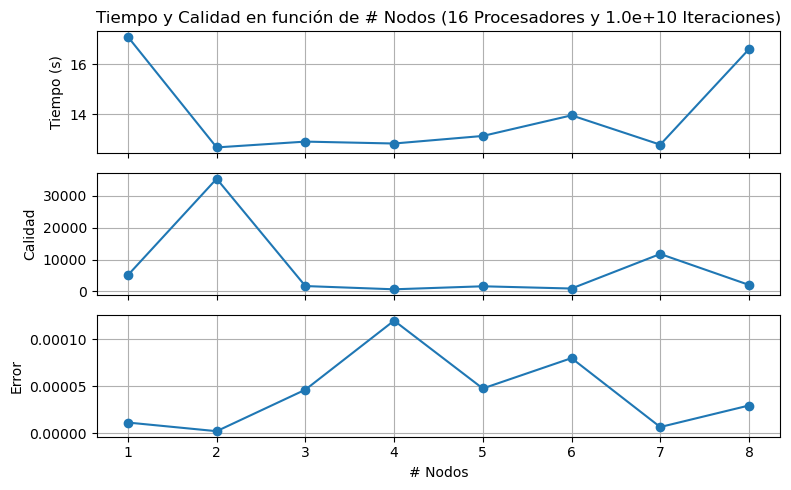

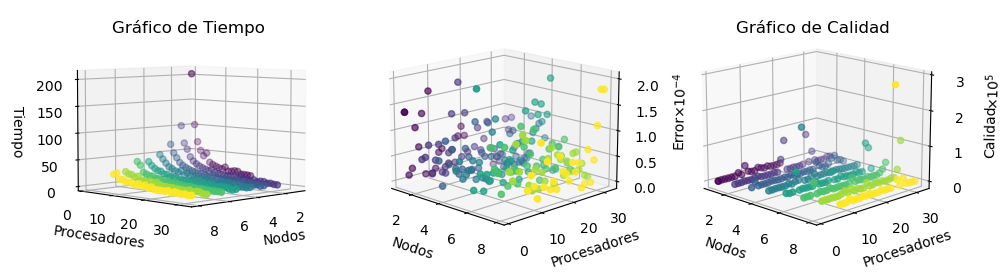

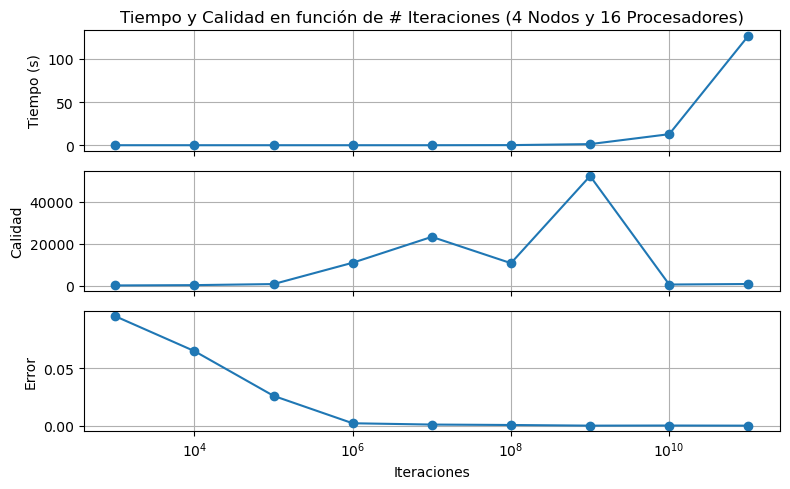

In [10]:
df = cargar_fichero("montecarlo_escalonado_2.out")
_ = grafica_en_funcion_de_procesadores(df, "montecarlo-escalonado")
_ = grafica_en_funcion_de_nodos(df, "montecarlo-escalonado")
_ = grafica_3D(df, "montecarlo-escalonado")
_ = grafica_en_funcion_de_iteraciones(df, "montecarlo-escalonado")